# OOF Accuracy Analysis

This notebook calculates the accuracy of OOF predictions for different models, stratified by:
1. Predicted Age Group (4 groups)
2. Original Age Group (15 groups)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [26]:
# Paths
PROJECT_ROOT = "d:/OneDrive/Desktop/The big project/ecg-ordinal-aging"
OOF_DIR = os.path.join(PROJECT_ROOT, "src/evaluation/OOF")
SUBJECT_INFO_PATH = os.path.join(PROJECT_ROOT, "data/raw/autonomic-aging-a-dataset/subject-info.csv")

# Check paths
print(f"OOF Directory exists: {os.path.exists(OOF_DIR)}")
print(f"Subject Info exists: {os.path.exists(SUBJECT_INFO_PATH)}")

OOF Directory exists: True
Subject Info exists: True


In [27]:
# Load Subject Info
subject_info = pd.read_csv(SUBJECT_INFO_PATH, dtype={'ID': str})
print(f"Loaded subject info with {len(subject_info)} records")

# Filter out NaN Age_group
subject_info = subject_info.dropna(subset=['Age_group'])
subject_info['Age_group'] = subject_info['Age_group'].astype(int)

# Define Mapping from 15 groups to 4 groups (for verification/plotting)
mapping_15_to_4 = {
    1: 0, 2: 0, 3: 0,
    4: 1, 5: 1,
    6: 2, 7: 2,
    8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3
}

# Add mapped label to subject_info for checking
subject_info['mapped_label'] = subject_info['Age_group'].map(mapping_15_to_4)

Loaded subject info with 1121 records


In [28]:
def analyze_oof_file(filepath, subject_df):
    try:
        # Load OOF
        oof_df = pd.read_csv(filepath, dtype={'ID': str})
        
        # Merge with subject info to get the original 15-group label
        # We also keep 'mapped_label' which is the ground truth 4-class label derived from Age_group
        merged = pd.merge(oof_df, subject_df[['ID', 'Age_group', 'mapped_label']], on='ID', how='inner')
        
        # Calculate Correctness
        # Note: y_true in OOF should match mapped_label. 
        # The model predicts the 4-group label (y_pred).
        merged['correct'] = (merged['y_pred'] == merged['y_true']).astype(int)
        
        # Accuracy per 4 groups (predicted/target class)
        # We group by 'y_true' (the ground truth 4-class label) to see accuracy per class
        acc_per_4_group = merged.groupby('y_true')['correct'].mean()
        
        # Rename index for better readability
        label_map_4 = {
            0: "0 (18-29)",
            1: "1 (30-39)",
            2: "2 (40-49)",
            3: "3 (50-92)"
        }
        # Ensure index is int before mapping
        acc_per_4_group.index = acc_per_4_group.index.map(label_map_4)
        
        # Accuracy per 15 groups
        # We group by 'Age_group' (the original 15-class label)
        acc_per_15_group = merged.groupby('Age_group')['correct'].mean()
        
        return acc_per_4_group, acc_per_15_group, len(merged)
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None, 0

In [29]:
# Process all OOF files
oof_files = glob.glob(os.path.join(OOF_DIR, "*oof_predictions.csv"))

results_4_group = {}
results_15_group = {}

for f in oof_files:
    model_name = os.path.basename(f).replace("_oof_predictions.csv", "")
    print(f"Processing {model_name}...")
    
    acc4, acc15, count = analyze_oof_file(f, subject_info)
    
    if acc4 is not None:
        results_4_group[model_name] = acc4
        results_15_group[model_name] = acc15
        print(f"  Processed {count} samples.")

Processing Resnet34_coral_20260210-160027...
  Processed 3356 samples.
Processing Resnet34_FocalCos_20260207-004554...
  Processed 3356 samples.
Processing Resnet34_hybrid_20260206-160910...
  Processed 3356 samples.


In [33]:
# Visualization function
def plot_accuracies(results_dict, xlabel, title, figsize=(12, 6)):
    if not results_dict:
        print("No results to plot.")
        return
        
    df_results = pd.DataFrame(results_dict)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Bar plot cho các model (giữ nguyên để hiện chú thích)
    df_results.plot(kind='bar', ax=ax, width=0.8, alpha=0.7)
    
    # Vẽ các đường kẻ nhưng đặt label ẩn
    for col in df_results.columns:
        try:
            x_coords = range(len(df_results.index))
            # Thay đổi label thành "_nolegend_" để ẩn khỏi chú thích
            ax.plot(x_coords, df_results[col], marker='o', linestyle='-', linewidth=2, label='_nolegend_')
        except Exception as e:
             print(f"Could not plot line for {col}: {e}")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    
    # Chú thích bây giờ sẽ chỉ hiển thị các cột (bar) từ df_results.plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

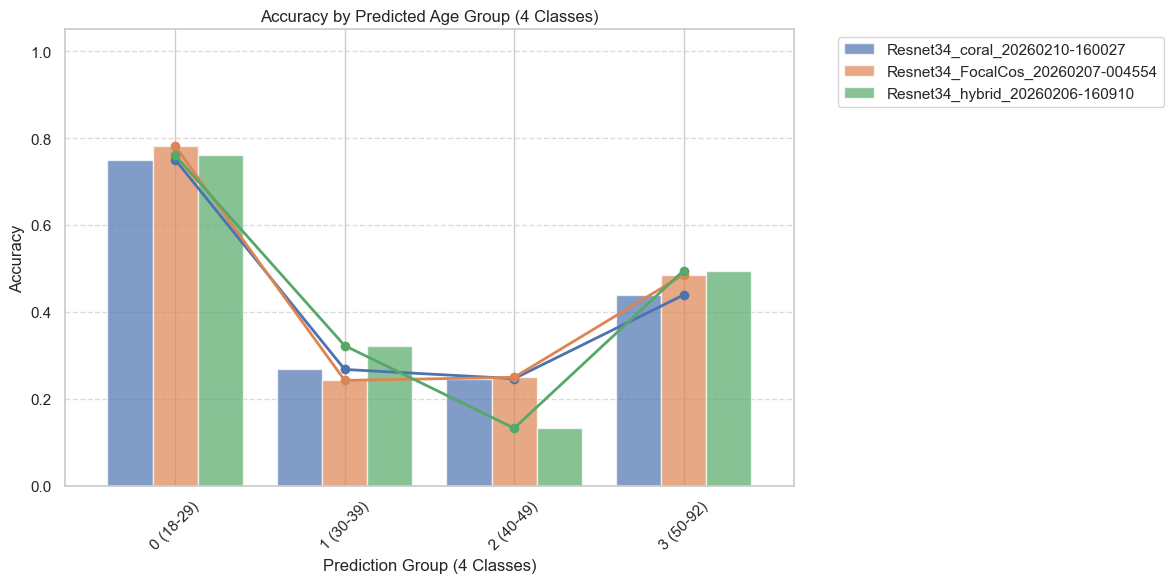

In [34]:
# Plot for 4 Groups
plot_accuracies(results_4_group, "Prediction Group (4 Classes)", "Accuracy by Predicted Age Group (4 Classes)")

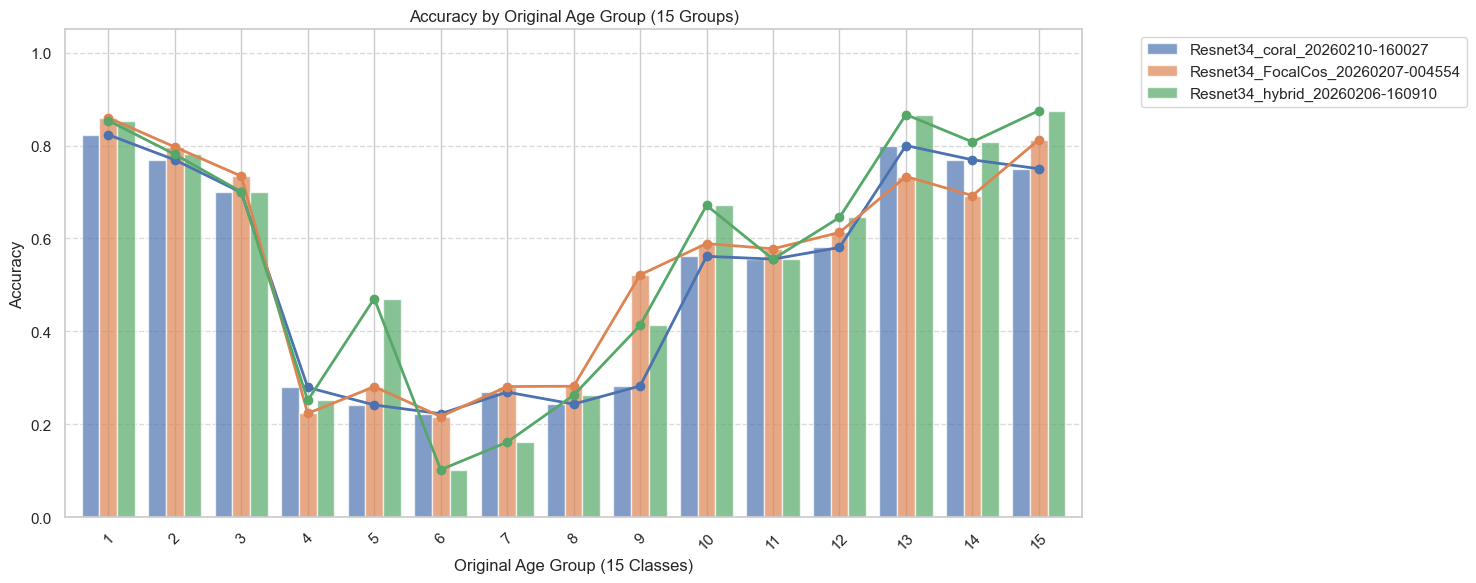

In [35]:
# Plot for 15 Groups
plot_accuracies(results_15_group, "Original Age Group (15 Classes)", "Accuracy by Original Age Group (15 Groups)", figsize=(15, 6))